In [92]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms.functional import resize
from torch.nn.functional import softmax
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [93]:
SEED = 42
LR = 1e-3
WEIGHT_DECAY = 1e-4
BATCH_SIZE = 200
NUMBER_EPOCHS = 20

IMG_SIZE  = 28
CLASSES = 10

if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')
print(DEVICE)

torch.manual_seed(SEED)

cuda


In [94]:
trns = transforms.Compose([
  transforms.Resize((32, 32)),
  transforms.ToTensor(),
])

In [95]:
train_set = datasets.MNIST('./train', train=True, download=True, transform=trns)
test_set = datasets.MNIST('./test', train=False, download=True , transform=trns)

In [96]:
train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

test_loader = DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

In [97]:
class LeNet5(nn.Module):
  def __init__(self):
    super(LeNet5, self).__init__()

    self.layers = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5, 5)),
        nn.ReLU(),
        nn.MaxPool2d((2, 2)),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5, 5)),
        nn.ReLU(),
        nn.MaxPool2d((2, 2)),
        nn.Conv2d(in_channels=16, out_channels=120, kernel_size=(5, 5)),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(in_features=120, out_features=84),
        nn.ReLU(),
        nn.Linear(in_features=84, out_features=10),
    )

  def forward(self, X):
    return self.layers(X)

In [98]:
net = LeNet5().to(DEVICE)

In [99]:
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.Adam(net.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

In [100]:
def train_nn(train_loader, net, criterion, optimizer):
  val_train = []
  net.train()
  for batch in train_loader:
    optimizer.zero_grad()
    data, label = batch

    data = data.to(DEVICE)
    label = label.to(DEVICE)

    predicted = net(data)
    loss = criterion(predicted, label)
    val_train.append(loss.cpu().data)

    loss.backward()
    optimizer.step()
  return np.asarray(val_train)

In [101]:
def validation_nn(test_loader, net, criterion, optimizer):
  val_loss = []
  net.eval()
  with torch.no_grad():
    for batch in train_loader:
      data, label = batch

      data = data.to(DEVICE)
      label = label.to(DEVICE)

      predicted = net(data)
      loss = criterion(predicted, label)
      val_loss.append(loss.cpu().data)
  return np.asarray(val_loss)

In [102]:
def run_train(train_loader, test_loader, net, criterion, optimizer, epochs):
  loss = []
  for epoch in range(epochs):
    train_loss = train_nn(train_loader, net, criterion, optimizer)
    val_loss = validation_nn(test_loader, net, criterion, optimizer)
    loss.append((train_loss, val_loss))
    print(f'EPOCH {epoch} -> Loss: {train_loss.mean()} (train) | {val_loss.mean()} (val)')
  return np.asarray(loss)

In [103]:
loss = run_train(train_loader, test_loader, net, criterion, optimizer, 7)

EPOCH 0 -> Loss: 0.4592384994029999 (train) | 0.13747474551200867 (val)
EPOCH 1 -> Loss: 0.11084388941526413 (train) | 0.08169329166412354 (val)
EPOCH 2 -> Loss: 0.07706055045127869 (train) | 0.0631556287407875 (val)
EPOCH 3 -> Loss: 0.061375975608825684 (train) | 0.05146330967545509 (val)
EPOCH 4 -> Loss: 0.04943333938717842 (train) | 0.04020373150706291 (val)
EPOCH 5 -> Loss: 0.042449310421943665 (train) | 0.03433410823345184 (val)
EPOCH 6 -> Loss: 0.037407148629426956 (train) | 0.030309878289699554 (val)


In [104]:
treated_loss  = [(t.mean(), v.mean()) for (t, v) in loss]

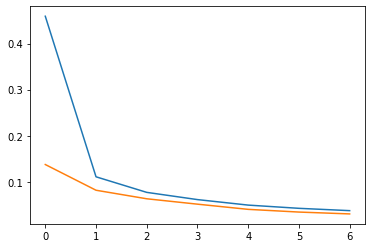

In [105]:
plt.plot(treated_loss)

In [135]:
def run_net(net, img: torch.tensor, DEVICE: torch.device):
  img = img.unsqueeze(0)
  img = resize(img, size=(32, 32))
  img = img.unsqueeze(0).to(dtype=torch.float32).to(DEVICE)
  pred = net(img)
  return torch.argmax(softmax(pred, dim=1)).cpu().data

In [136]:
img = test_set.data[0]
run_net(net, img, DEVICE)

tensor(7)

In [137]:
test_set.targets[0]

tensor(7)